In [1]:
import tensorflow_core as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import pandas as pd
import seaborn as sb
import scipy as sp
import sklearn.preprocessing as skp
import sklearn.model_selection as skm

import sys
import os

np.set_printoptions(threshold=sys.maxsize)

In [2]:
air_bnb = pd.read_csv("./airbnb.csv")

dataset = air_bnb[["latitude", "longitude", "id"]].to_numpy()

scaler = skp.StandardScaler()
scaler.fit(dataset)

dataset = scaler.transform(dataset)

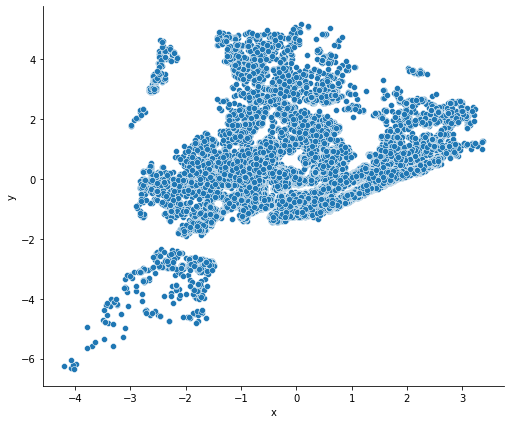

In [3]:
df = pd.DataFrame(dataset[:, 0:2], columns=["x", "y"])
sb.relplot(x="x", y="y", data=df, kind="scatter", height=6, aspect=1.2)

In [4]:
max_training_epochs = 2000

neurons_diff_stop_cond = 0.0001

# 64 (8 * 8) neurons
width = 8
height = 8
num_neurons = width * height

# init sigma value = max(width, height) / 2
init_sigma = 4.0

learning_rate = 0.3

# dimension, depend on number of features
dim = 2

In [5]:
x = tf.placeholder(tf.float32, [dim])
iter = tf.placeholder(tf.float32)

# (w x h) neurons, contains weight
neurons = tf.Variable(tf.random_normal([width * height, dim]))

In [6]:
locs = [[x, y] for y in range(height) for x in range(width)]
# neurons locations
neu_locs = tf.cast(tf.convert_to_tensor(locs), tf.float32)

In [7]:
expanded_x = tf.expand_dims(x, 0)

mse_to_neurons_by_weight = tf.reduce_mean(
    tf.square(tf.subtract(expanded_x, neurons)), 1
)

min_mse_idx = tf.argmin(mse_to_neurons_by_weight, 0)

bmu_loc = tf.cast(tf.stack(
    [tf.floormod(min_mse_idx, width), tf.floordiv(min_mse_idx, width)]
), tf.float32)

In [8]:
# decay_rate = tf.subtract(1.0, tf.divide(iter, max_training_epochs))
decay_rate = tf.exp(tf.divide(tf.multiply(-1.0, iter), max_training_epochs))

alpha = tf.multiply(decay_rate, learning_rate)
sigma = tf.multiply(decay_rate, init_sigma)

expanded_bum_loc = tf.expand_dims(bmu_loc, 0)
mse_to_neurons_by_lateral = tf.reduce_mean(
    tf.square(tf.subtract(expanded_bum_loc, neu_locs)), 1
)

neighbor_factor = tf.exp(
    tf.divide(
        tf.multiply(-1.0, mse_to_neurons_by_lateral),\
        tf.multiply(2.0, tf.square(sigma))
    )
)

learning_factor = tf.multiply(alpha, neighbor_factor)

i = tf.constant(0)
m0 = tf.constant([[-99.0] * dim])  # dummy

c = lambda i, m: tf.less(i, num_neurons)
b = lambda i, m: [
    tf.add(i, 1),
    tf.concat(
        [m, tf.expand_dims(tf.tile(tf.slice(learning_factor, [i], [1]), [dim]), 0)], 0
    ),
]
tile = tf.while_loop(
    c,
    b,
    loop_vars=[i, m0],
    shape_invariants=[i.get_shape(), tf.TensorShape([None, dim])],
)

learning_factor_grid = tf.slice(tile[1], [1, 0], [num_neurons, dim])  # remove dummy

# vector from neurons to x = x - neurons
distance_vectors = tf.subtract(tf.expand_dims(x, 0), neurons)

neurons_diff = tf.multiply(learning_factor_grid, distance_vectors)

update_neurons = tf.assign(neurons, tf.add(neurons, neurons_diff))

In [9]:
sess = tf.Session()
init = (tf.global_variables_initializer())
sess.run(init)

variance = np.float32(-1.)
for i in range(max_training_epochs):
    _variance = np.float32(0.)
    for data in dataset:
        _, diff = sess.run([update_neurons, neurons_diff], \
                    feed_dict={x: data[0:2], iter: i})
        
        _variance += np.sum(
            np.mean(np.absolute(diff), axis=1))

    _variance = _variance / dataset.shape[0] 
    
    if variance == -1.: variance = _variance
    elif np.absolute(variance - _variance) <= neurons_diff_stop_cond:
            break
    else: variance = _variance
    
    print(variance)
    if variance <= neurons_diff_stop_cond:
        break

9.24940305757235
9.239464030064424
9.230667757439411
9.222048522343798
9.212505752121894
9.204477707332037
9.195939641067595
9.186898583699765
9.177335361488904
9.168503937007873
9.159547244094489
9.150894135392166
9.14184029553124
9.132868902750792
9.12389303609776
9.115270605378873
9.106366959811842
9.098227068207382
9.0896116678597
9.081186726659167
9.07183377645976
9.06293013089273
9.05386670416198
9.044695904489211
9.035978883321404
9.027907378055016
9.019560410062379
9.010649094999488
9.002215206053789
8.993911698537683
8.985045122200635
8.97639968299417
8.967768304530116
8.958959249412006
8.950715819613457
8.942235913692606
8.93381288986604
8.925026843235505
8.916348169546989
8.907698256467942
8.898909653338787
8.890426551794661
8.881919163513652
8.873412414357297
8.864949764802127
8.856235939257592
8.847785433070866
8.839106120257695
8.83042105532263


KeyboardInterrupt: 

In [109]:
# # both output grid will do, just output different cluster order
# centroid_grid1 = [[] for i in range(width)] # output 2D grid base on width
# centroid_grid2 = [[] for i in range(height)] # output 2D grid base on height
# 
centroids = sess.run(neurons)
# locs_val = list(sess.run(neu_locs))
# 
# print(sess.run(neurons))
# 
# for i, l in enumerate(locs_val):
#     centroid_grid1[int(l[0])].append(node_val[i])
#     centroid_grid2[int(l[1])].append(node_val[i])
#     
# print(np.array(centroid_grid1))

[[ 0.45445082 -0.3422103 ]
 [ 0.3995341  -0.29877812]
 [ 0.32717413 -0.23085555]
 [ 0.23590016 -0.14109552]
 [ 0.12855792 -0.03514723]
 [ 0.01239599  0.07901809]
 [ 0.49326274 -0.319099  ]
 [ 0.43763685 -0.27249795]
 [ 0.36453316 -0.20089945]
 [ 0.27190742 -0.10692422]
 [ 0.16223985  0.00368817]
 [ 0.04289288  0.12273547]
 [ 0.5293929  -0.27163017]
 [ 0.47150078 -0.2205986 ]
 [ 0.39613426 -0.14439261]
 [ 0.3011346  -0.04579659]
 [ 0.18901414  0.06914105]
 [ 0.06732971  0.19181672]
 [ 0.56497383 -0.2020663 ]
 [ 0.5031711  -0.14529973]
 [ 0.4239083  -0.06352322]
 [ 0.32541966  0.04010256]
 [ 0.21069187  0.1589658 ]
 [ 0.08756489  0.28385705]
 [ 0.60074085 -0.11530539]
 [ 0.5337169  -0.05189921]
 [ 0.44944316  0.03589188]
 [ 0.34696394  0.14434417]
 [ 0.23000439  0.26612073]
 [ 0.10658464  0.3913983 ]]


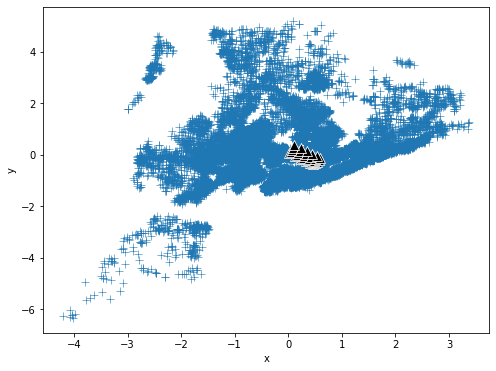

In [110]:
colors = sb.color_palette("Paired", 10)

fig = plt.gcf()
fig.set_size_inches(8, 6)

df = pd.DataFrame(dataset[:, 0:2], columns=["x", "y"])
sb.scatterplot(data=df, x="x", y="y",\
            marker="+", s=50)

df_centr = pd.DataFrame(centroids,\
            columns=["x", "y"])
sb.scatterplot(data=df_centr, x="x", y="y",\
    marker="^", color="#000", s=100)

plt.show()